In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## 1. Load standardized data

In [9]:
X_scaled_df = pd.read_csv('../dataset/user_scaled.csv')
id_col = 'visitorid'
print("Skewness check from Data Prep:")
print(X_scaled_df.skew())
cols_features = ['Recency', 'Frequency', 'Monetary', 'Conversion_Rate']
X_final = X_scaled_df[[id_col] + cols_features].copy()
X_clustering = X_final[cols_features].values
print("Features used for clustering:", cols_features)

Skewness check from Data Prep:
visitorid         -0.026269
Recency            0.100507
Frequency          4.870120
Monetary           0.532453
Conversion_Rate    4.890277
dtype: float64
Features used for clustering: ['Recency', 'Frequency', 'Monetary', 'Conversion_Rate']


## 2. Finding Optimal K
We use the **Elbow Method** and **Silhouette Score** to determine the optimal number of clusters. PCA is skipped as it was found to retain 100% variance with 4 components, making it equivalent to using the original scaled features.

Running experiments to find optimal K...
k=2: Inertia=37625.84, Silhouette=0.2354
k=3: Inertia=29868.09, Silhouette=0.2566
k=4: Inertia=25561.84, Silhouette=0.2666
k=5: Inertia=21628.17, Silhouette=0.2536
k=6: Inertia=19942.63, Silhouette=0.2455
k=7: Inertia=17513.87, Silhouette=0.2395
k=8: Inertia=16572.90, Silhouette=0.2144
k=9: Inertia=14918.82, Silhouette=0.2357
k=10: Inertia=14147.72, Silhouette=0.2340


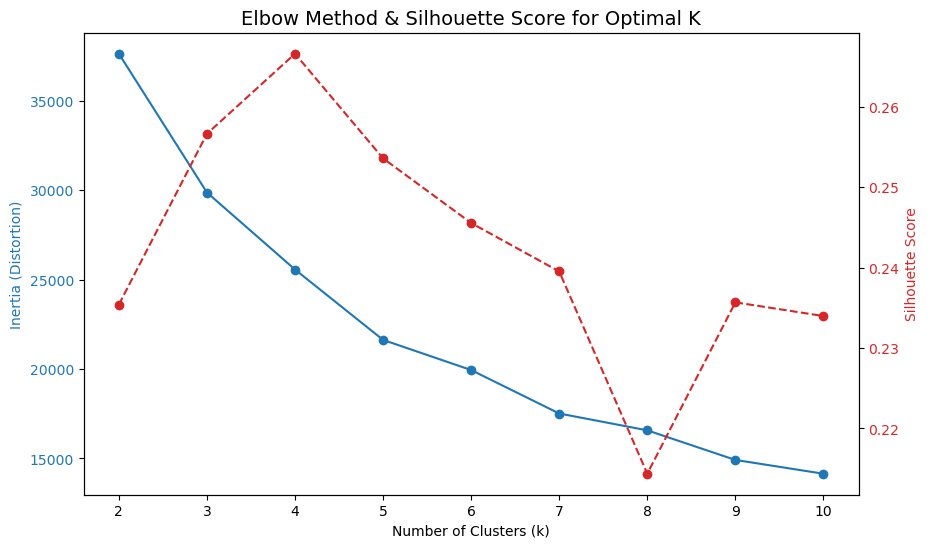

In [10]:
inertia = []
silhouette_scores = []
k_range = range(2, 11)

print("Running experiments to find optimal K...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_clustering)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X_clustering, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={score:.4f}")

# Plotting Elbow and Silhouette
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Distortion)', color=color)
ax1.plot(k_range, inertia, marker='o', color=color, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k_range, silhouette_scores, marker='o', linestyle='--', color=color, label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow Method & Silhouette Score for Optimal K', fontsize=14)
plt.show()

## 3. Modeling with K=4
Based on general RFM interpretation (often 3-5 segments) and previous analysis, we proceed with K=4. This provides granularity without over-segmenting.

In [11]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
X_final['Cluster'] = kmeans.fit_predict(X_clustering)

print("Cluster distribution:")
print(X_final['Cluster'].value_counts().sort_index())

Cluster distribution:
Cluster
0    5257
1     996
2     562
3    4904
Name: count, dtype: int64


## 4. Cluster Profiling (Snake Plot)
We visualize the standardized feature values for each cluster to understand their characteristics.

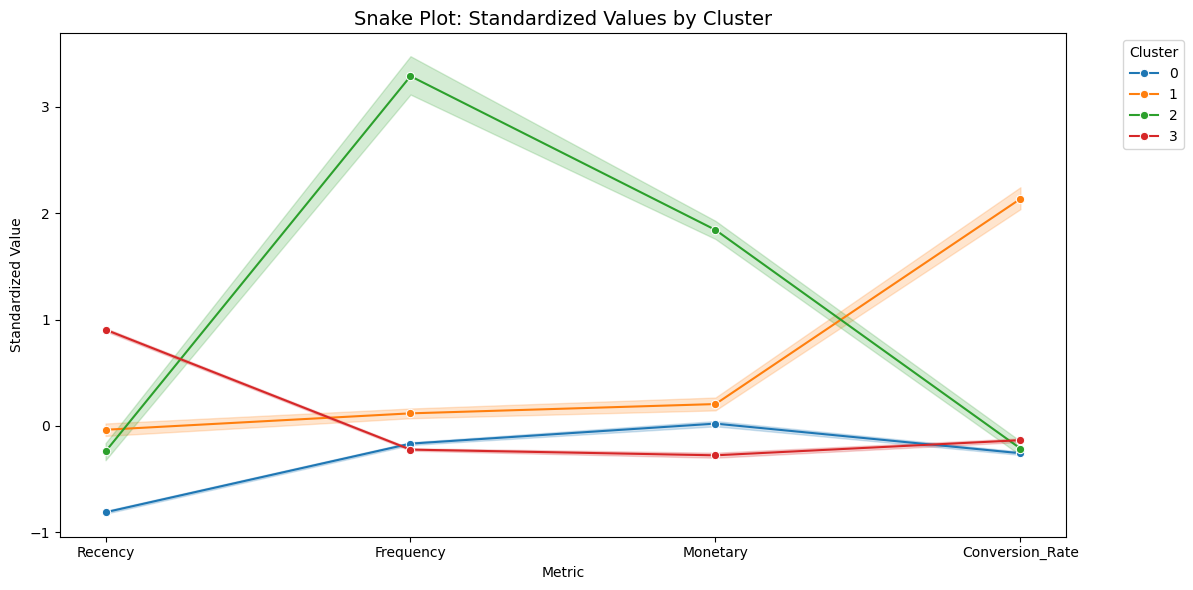

In [12]:
X_final_melt = pd.melt(
    X_final.reset_index(),
    id_vars=['visitorid', 'Cluster'],
    value_vars=cols_features,
    var_name='Metric',
    value_name='Value'
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=X_final_melt, x='Metric', y='Value', hue='Cluster', palette='tab10', marker='o')
plt.title('Snake Plot: Standardized Values by Cluster', fontsize=14)
plt.xlabel('Metric')
plt.ylabel('Standardized Value')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 5. Relative Importance Heatmap
Visualizing the mean of each feature per cluster.

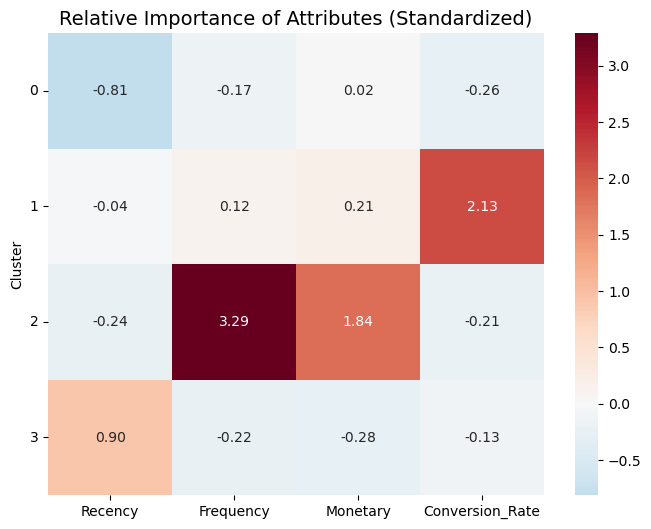

In [13]:
cluster_avg = X_final.groupby('Cluster')[cols_features].mean()

plt.figure(figsize=(8, 6))
sns.heatmap(cluster_avg, annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Relative Importance of Attributes (Standardized)', fontsize=14)
plt.yticks(rotation=0)
plt.show()

## 6. Interactive 3D Visualization
Interactive 3D scatter plot using Plotly to explore Recency, Frequency, and Monetary dimensions.

In [14]:
# Ensure Cluster is treated as categorical for discrete colors
X_final['Cluster_Label'] = X_final['Cluster'].astype(str)

fig = px.scatter_3d(
    X_final,
    x='Recency',
    y='Frequency',
    z='Monetary',
    color='Cluster_Label',
    title='Interactive 3D View of Clusters (RFM)',
    opacity=0.7,
    size_max=10,
    # Hover data to show more info
    hover_data=['visitorid', 'Conversion_Rate']
)

# Update marker size
fig.update_traces(marker=dict(size=3))

fig.show()